<a href="https://colab.research.google.com/github/AdityaVerma2809/Rockfall-Prediction-and-Alert-System-for-Open-Pit-Mines/blob/main/Rockfall_prediction_demo_geotechnical_sensors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Context and Scope

#### Overview
The **PitMine Flare - An AI-Powered Predictive Rockfall Monitoring and Alert System** is designed to enhance safety and operational efficiency in open-pit mining. By integrating geotechnical sensors (strain, pore pressure, vibration), drone imagery, Digital Elevation Models (DEMs), and environmental conditions (rainfall, temperature), the system leverages machine learning to generate real-time risk maps, probability-based forecasts, and automated alerts. This approach ensures safer mining practices, optimized operations, and cost-effective risk management, as outlined in the project documentation.

#### Current Focus
The geotechnical sensor model uses synthetic time-series data to train an LSTM model, evaluated with metrics like accuracy, precision, recall, and F1-score, and visualized with 2D and 3D plots.
#### Future Work
Real-time LiDAR and DEM models are under development to process drone-captured imagery and elevation data, aligning with the project's methodology of multi-source data integration. These will be integrated into a web/dashboard interface and mobile application, as specified, to provide 3D visualizations and automated alerts.

#### Research Purpose
The 3D plotting of sensor streams and environmental inputs is included to explore relationships that may indicate upcoming rockfall events, supporting further model refinement.

#### Limitations and Roadmap
This notebook represents a work-in-progress snapshot, utilizing synthetic data due to current constraints. The ongoing work on LiDAR and DEM models, along with the full dashboard and alert system, will address these limitations, aligning with the project's scalability and sustainability goals. The roadmap includes incremental deployment, adaptive model retraining, and global dataset aggregation to enhance performance across multiple mine sites.The enhancements are actively being pursued to deliver a robust, real-time monitoring solution.

# Generating Synthetic Data

**Strain**: Measures deformation; simulate as increasing gradually, with spikes before rockfalls (e.g., using sine waves + noise + ramps).

**Pore Pressure**: Increases with rainfall; high values reduce slope stability (simulated via cumulative rainfall effect).

**Vibration**: From mining blasts/traffic; random spikes.

**Rainfall: Daily precipitation (mm)**; use random walks or periodic patterns.
Temperature: Daily fluctuations (°C); low temps might simulate freeze-thaw weakening.

**Target (Risk)**: Binary label. Calculate using a simplified "Factor of Safety" (FoS) formula inspired by geotechnical models (e.g., FoS < 1 indicates instability). A basic proxy: Risk = 1 if (high pore pressure + high strain + high vibration + heavy rainfall + extreme temp) exceeds a threshold. Add noise for realism.

We need time-series data simulating sensor readings over, say, 1000 timesteps (e.g., hourly readings over ~40 days).

In [2]:
import numpy as np
import pandas as pd

In [3]:
# Parameters
num_samples = 1000  # Timesteps
np.random.seed(42)  # For reproducibility
time = np.arange(num_samples)

Creating synthetic inputs

In [4]:
# Environmental inputs
rainfall = np.abs(np.random.normal(5, 10, num_samples))  # mm/day, occasional heavy rain
temperature = 20 + 10 * np.sin(2 * np.pi * time / 24) + np.random.normal(0, 2, num_samples)  # °C, daily cycle + noise

# Geotechnical sensors (influenced by environment)
strain = 0.001 * time + np.random.normal(0, 0.01, num_samples)  # Increasing deformation + noise
pore_pressure = np.cumsum(rainfall) / 10 + np.random.normal(0, 5, num_samples)  # Builds up with rain
vibration = np.random.exponential(1, num_samples)  # Spikes for blasts

noise = np.random.normal(0, 0.1, num_samples)
fos_proxy = 1 / (strain + pore_pressure/100 + vibration + rainfall/10 - temperature/50 + noise + 1e-5)
risk = (fos_proxy < 1).astype(int)  # 1 = high risk, 0 = low

In [5]:
# Create DataFrame
data = pd.DataFrame({
    'time': time,
    'strain': strain,
    'pore_pressure': pore_pressure,
    'vibration': vibration,
    'rainfall': rainfall,
    'temperature': temperature,
    'risk': risk
})

# Save to CSV to prototype
data.to_csv('synthetic_rockfall_data.csv', index=False)

In [6]:
print(len(data))
print(data.head())
print(f"Risk distribution: {data['risk'].value_counts(normalize=True)}")

1000
   time    strain  pore_pressure  vibration   rainfall  temperature  risk
0     0 -0.006752      -8.542324   0.663623   9.967142    22.798711     1
1     1 -0.000445      -2.943475   0.089272   3.617357    24.437458     1
2     2 -0.005924       0.438111   3.592166  11.476885    25.119261     1
3     3 -0.000080      13.967607   0.729833  20.230299    25.777194     1
4     4 -0.014936       7.577780   0.952401   2.658466    30.056701     0
Risk distribution: risk
1    0.966
0    0.034
Name: proportion, dtype: float64


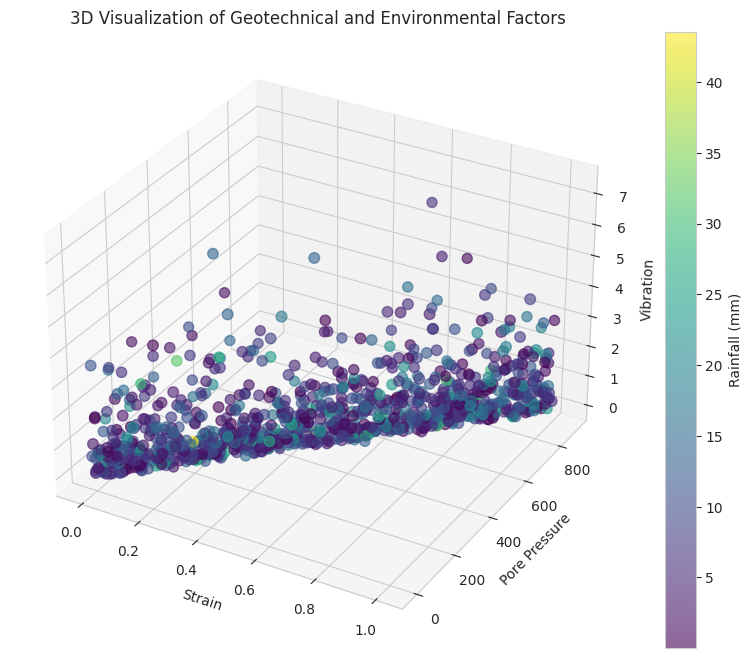

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = pd.read_csv('synthetic_rockfall_data.csv')
strain = data['strain'].values
pore_pressure = data['pore_pressure'].values
vibration = data['vibration'].values
rainfall = data['rainfall'].values
temperature = data['temperature'].values
risk = data['risk'].values

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(strain, pore_pressure, vibration, c=rainfall, cmap='viridis', s=50 + 10 * (temperature - np.min(temperature)) / (np.max(temperature) - np.min(temperature)), alpha=0.6)
plt.colorbar(scatter, label='Rainfall (mm)')

ax.set_xlabel('Strain')
ax.set_ylabel('Pore Pressure')
ax.set_zlabel('Vibration')
ax.set_title('3D Visualization of Geotechnical and Environmental Factors')

plt.savefig('3d_geotechnical_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Preprocessing

Load the data, normalize features (sensors can have different scales), and prepare sequences for LSTM (e.g., use past 24 timesteps to predict the next risk).

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

In [8]:
# Load data
data = pd.read_csv('synthetic_rockfall_data.csv')
features = ['strain', 'pore_pressure', 'vibration', 'rainfall', 'temperature']
X = data[features].values
y = data['risk'].values

In [9]:
X[0]

array([-6.75178275e-03, -8.54232364e+00,  6.63623306e-01,  9.96714153e+00,
        2.27987109e+01])

In [10]:
y[0]

np.int64(1)

In [11]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Create sequences (time-series windows)
seq_length = 24  # Use past 24 hours to predict next
X_seq, y_seq = [], []
for i in range(len(X_scaled) - seq_length):
    X_seq.append(X_scaled[i:i+seq_length])
    y_seq.append(y[i+seq_length])  # Predict next risk

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [13]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [14]:
# PyTorch Dataset
class RockfallDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # For binary classification

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RockfallDataset(X_train, y_train)
test_dataset = RockfallDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM Model

In [15]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

In [16]:
class RockfallLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2):
        super(RockfallLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output: risk probability
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])  # Last hidden state
        return self.sigmoid(out)

# Initialize model
model = RockfallLSTM()
criterion = nn.BCELoss()  # Binary cross-entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train

In [17]:
epochs = 50
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.0554
Epoch 2/50, Loss: 0.6758
Epoch 3/50, Loss: 0.0259
Epoch 4/50, Loss: 0.0289
Epoch 5/50, Loss: 0.0274
Epoch 6/50, Loss: 0.3347
Epoch 7/50, Loss: 0.0303
Epoch 8/50, Loss: 0.0257
Epoch 9/50, Loss: 0.0263
Epoch 10/50, Loss: 0.0279
Epoch 11/50, Loss: 0.6673
Epoch 12/50, Loss: 0.6264
Epoch 13/50, Loss: 0.0346
Epoch 14/50, Loss: 0.0262
Epoch 15/50, Loss: 0.0425
Epoch 16/50, Loss: 0.3602
Epoch 17/50, Loss: 0.0347
Epoch 18/50, Loss: 0.0301
Epoch 19/50, Loss: 0.2912
Epoch 20/50, Loss: 0.2289
Epoch 21/50, Loss: 0.3833
Epoch 22/50, Loss: 0.1521
Epoch 23/50, Loss: 0.0197
Epoch 24/50, Loss: 0.0822
Epoch 25/50, Loss: 0.0568
Epoch 26/50, Loss: 0.0881
Epoch 27/50, Loss: 0.2766
Epoch 28/50, Loss: 0.0024
Epoch 29/50, Loss: 0.0021
Epoch 30/50, Loss: 0.0799
Epoch 31/50, Loss: 0.0032
Epoch 32/50, Loss: 0.0359
Epoch 33/50, Loss: 0.0373
Epoch 34/50, Loss: 0.1043
Epoch 35/50, Loss: 0.0031
Epoch 36/50, Loss: 0.0702
Epoch 37/50, Loss: 0.0009
Epoch 38/50, Loss: 0.0397
Epoch 39/50, Loss: 0.

Evaluation

In [19]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# Ensure seaborn style for better visuals
sns.set_style("whitegrid")

# Evaluate
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    try:
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Binary prediction
            y_true.extend(labels.cpu().numpy())  # Move to CPU and convert
            y_pred.extend(predicted.cpu().numpy())  # Move to CPU and convert
    except Exception as e:
        print(f"Error in data collection: {e}")
        exit()

# Convert to NumPy arrays and check validity
y_true = np.array(y_true)
y_pred = np.array(y_pred)

if len(y_true) == 0 or len(y_pred) == 0:
    print("Error: No data collected for evaluation.")
    exit()

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Low Risk', 'High Risk'], zero_division=0))

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.00      0.00      0.00         4
   High Risk       0.98      0.99      0.98       192

    accuracy                           0.97       196
   macro avg       0.49      0.49      0.49       196
weighted avg       0.96      0.97      0.96       196



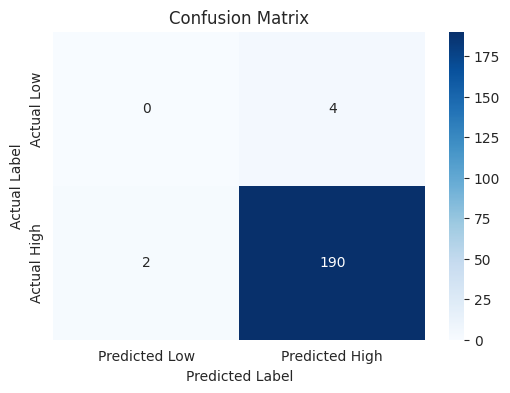

In [24]:
conf_matrix = confusion_matrix(y_true, y_pred)
if conf_matrix.size == 0:
    print("Error: Confusion matrix is empty.")
    exit()

plt.figure(figsize=(6, 4))
try:
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Low', 'Predicted High'],
                yticklabels=['Actual Low', 'Actual High'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"Error in plotting confusion matrix: {e}")



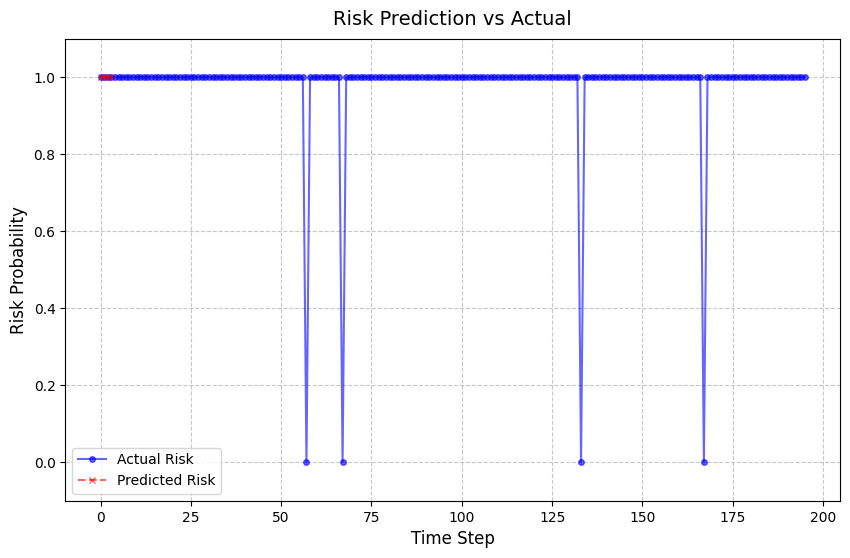

In [38]:
import matplotlib.pyplot as plt
import numpy as np

predicted = predicted.numpy() if hasattr(predicted, 'numpy') else predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Risk', color='blue', linestyle='-', marker='o', markersize=4, alpha=0.6)
plt.plot(predicted, label='Predicted Risk', color='red', linestyle='--', marker='x', markersize=4, alpha=0.6)
plt.title('Risk Prediction vs Actual', fontsize=14, pad=10)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Risk Probability', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(-0.1, 1.1)
plt.legend(fontsize=10)
plt.show()